In [1]:
from pathlib import Path

import imageio.v3 as iio
import numpy as np
import spiceypy as sp
from matplotlib import pyplot as plt

# We need to do it in a separate cell. See:
# https://github.com/jupyter/notebook/issues/3385
plt.style.use('default')
plt.rcParams.update({
    'font.family': 'latin modern math', 'font.size':12, 'mathtext.fontset':'stix',
    'axes.formatter.use_mathtext': True, 'axes.formatter.limits': (-4, 4),
    'axes.grid': True, 'grid.color': 'gray', 'grid.linewidth': 0.5,
    'xtick.top': True, 'ytick.right': True,
    'xtick.direction': 'inout', 'ytick.direction': 'inout',
    'xtick.minor.size': 2.0, 'ytick.minor.size': 2.0,  # default 2.0
    'xtick.major.size': 4.0, 'ytick.major.size': 4.0,  # default 3.5
    'xtick.minor.visible': True, 'ytick.minor.visible': True
})

FIGDIR = Path('temp/')
FIGDIR.mkdir(parents=True, exist_ok=True)

# Load necessary SPICE kernels
sp.furnsh('kernel_meta.txt')

# Get the G*M value of the Sun
_, GM_SUN = sp.bodvcd(bodyid=10, item='GM', maxn=1)
GM_SUN = GM_SUN[0]

SAMPLE_ET = sp.utc2et('2000-001T00:00:00')

# Compute the state vector of Jupiter in ECLIPJ2000 (Jupiter (599) is not
# available in the kernel, we use the barycentre (5))
vec_jup, _lt = sp.spkgeo(5, SAMPLE_ET, ref='J2000', obs=10)
elt_jup = sp.oscltx(vec_jup, SAMPLE_ET, GM_SUN)
A_JUP = sp.convrt(elt_jup[-2], "km", "au")

def tisserand_jup(a, e, i):
    """ Compute the Tisserand parameter with respect to Jupiter.

    Parameters
    ----------
    a : float
        Semi-major axis [au]
    e : float
        Eccentricity
    i : float
        Inclination [rad]
    """
    return A_JUP/a + 2 * np.cos(i) * np.sqrt((1 - e**2)*a/A_JUP)

In [2]:
ivals = np.linspace(0, np.pi/2, 100)
evals = np.linspace(0, 1, 100)
avals = np.arange(1.5, 8.1, 0.1)
ii, ee = np.meshgrid(ivals, evals)

for _a in avals:
    if _a % 1 < 0.01:
        print(f"{_a:.1f} au", end="... ")
    fig, ax = plt.subplots(1, 1, figsize=(8, 5), layout="constrained", gridspec_kw=None, sharex=False, sharey=False)

    tjvals = tisserand_jup(_a, ee, ii)
    im = ax.contourf(ee, np.rad2deg(ii), tjvals, vmin=2, vmax=4,
                 levels=np.linspace(2, 4, 11), extend="both")
    cb = fig.colorbar(im)
    cb.ax.set_ylabel(r"Tisserand parameter $T_J$")

    ax.set(
        title=r"Semi-major axis $a = {:.1f}$ au".format(_a),
        xlabel=r"Eccentricity $e$",
        ylabel=r"Inclination $i$ [deg]",
        xlim=(0, 1), ylim=(0, 90)
    )
    plt.savefig(FIGDIR / f"tisserand_jup_{_a:.1f}au.png", dpi=150, bbox_inches="tight")
    plt.clf()
    plt.close(fig)

2.0 au... 3.0 au... 4.0 au... 5.0 au... 6.0 au... 7.0 au... 8.0 au... 

In [4]:
files = FIGDIR.glob("tisserand_jup_*.png")
files = sorted(files)

im1 = iio.imread(files[0])
im2 = iio.imread(files[-1])

frames = [iio.imread(f) for f in files]
[frames.append(im2) for _ in range(10)]
frames.extend(frames[::-1])
[frames.append(im1) for _ in range(10)]

iio.imwrite(FIGDIR / "tisserand_animated_vis.gif", frames, duration=3)
# Duration does not work...

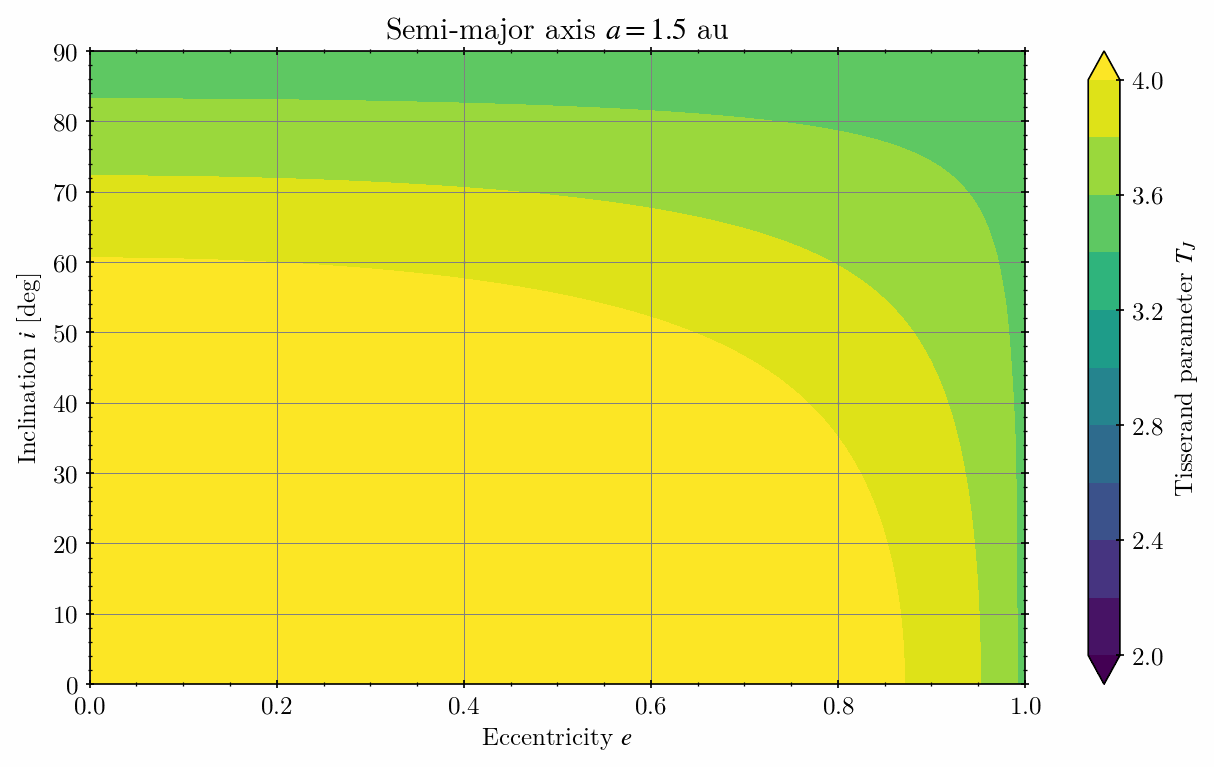

In [5]:
from IPython.display import Image
Image(FIGDIR / "tisserand_animated_vis.gif")